## Семинар 2 "Распознавание рукописных цифр"

ФИО: Лебедев Аркадий Ильич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [7]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)

HTTPError: HTTP Error 403: Forbidden

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

HTTPError: HTTP Error 403: Forbidden

In [19]:
import os

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_dir = '/raid/alebedev/Technopark/ANN/dl-course/lectures/lecture2/MNIST'

train_dataset = MNIST(root=data_dir, train=True, download=False, transform=transform)
test_dataset = MNIST(root=data_dir, train=False, download=False, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

RuntimeError: Dataset not found. You can use download=True to download it

In [2]:
from os.path  import join
import struct
from array import array
import random

In [3]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [4]:
# Set file paths based on added MNIST Datasets
training_images_filepath = './MNIST/raw/train-images.idx3-ubyte'
training_labels_filepath = './MNIST/raw/train-labels.idx1-ubyte'
test_images_filepath = './MNIST/raw/t10k-images.idx3-ubyte'
test_labels_filepath = './MNIST/raw/t10k-labels.idx1-ubyte'

In [5]:
# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

Loading MNIST dataset...
MNIST dataset loaded.


In [6]:
# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

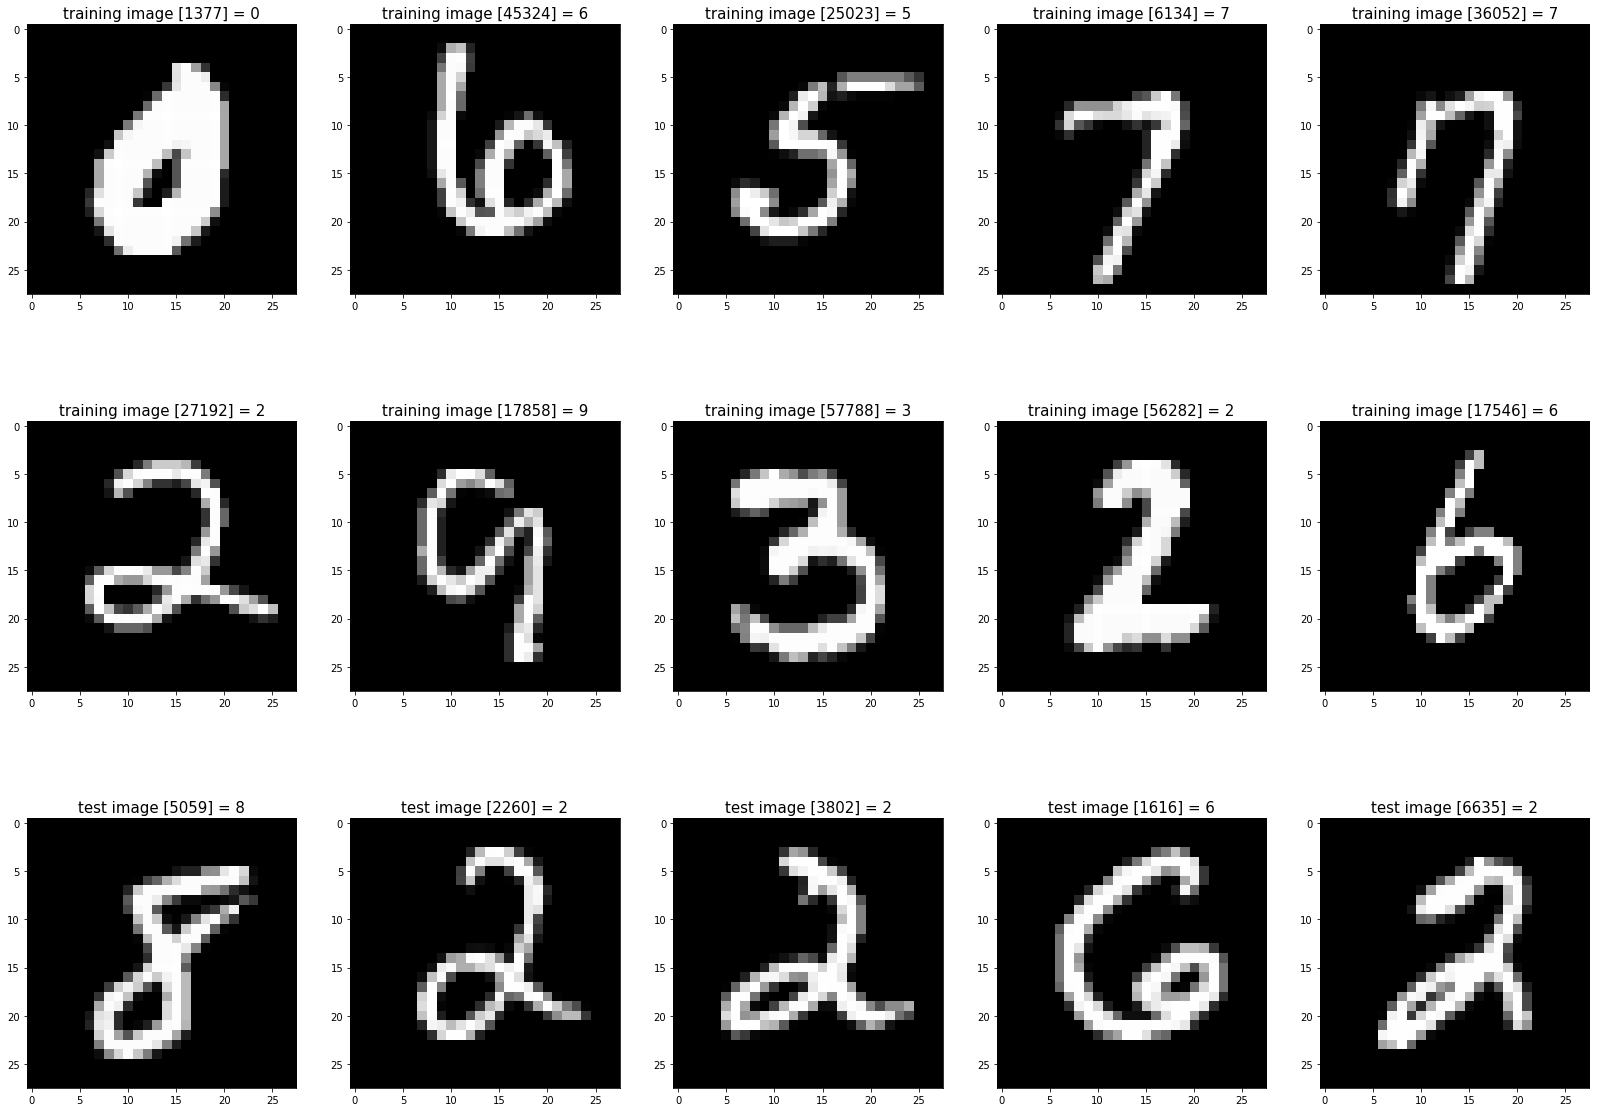

In [7]:
random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

In [9]:
type(x_train)

list

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

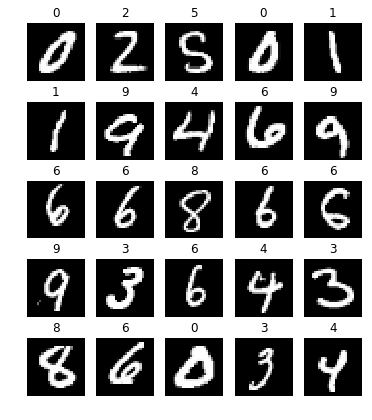

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [27]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [28]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

In [33]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [34]:
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))

In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, train_loader, test_loader)

IndexError: arrays used as indices must be of integer (or boolean) type

In [29]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

NameError: name 'train_loader' is not defined

# fix

In [47]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import sys
from IPython.display import clear_output

In [48]:
class MnistDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32) / 255.0  # Normalized
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [49]:
train_dataset = MnistDataset(x_train, y_train)
test_dataset = MnistDataset(x_test, y_test)

In [50]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [51]:
class NLLLoss:
    def forward(self, prediction, target):
        return -np.mean(np.log(prediction[range(target.shape[0]), target] + 1e-9))

    def backward(self, prediction, target):
        grad = prediction.copy()
        grad[range(target.shape[0]), target] -= 1
        return grad / target.shape[0]

In [52]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, dLdx):
        for layer in reversed(self.layers):
            dLdx = layer.backward(dLdx)

    def step(self, learning_rate):
        for layer in self.layers:
            layer.step(learning_rate)

In [53]:
class Linear:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros(output_size)
        self.input = None
        self.grad_weights = None
        self.grad_bias = None

    def forward(self, X):
        self.input = X
        return np.dot(X, self.weights) + self.bias

    def backward(self, dLdy):
        self.grad_weights = np.dot(self.input.T, dLdy)
        self.grad_bias = np.sum(dLdy, axis=0)
        return np.dot(dLdy, self.weights.T)

    def step(self, learning_rate):
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias

In [54]:
class Sigmoid:
    def __init__(self):
        self.output = None

    def forward(self, X):
        self.output = 1 / (1 + np.exp(-X))
        return self.output

    def backward(self, dLdy):
        return dLdy * self.output * (1 - self.output)

In [55]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), 
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])

In [56]:
def train(network, epochs, learning_rate, plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward(prediction, y)
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, axis=1) == y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, axis=1) == y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

In [57]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

/raid/alebedev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'Sigmoid' object has no attribute 'step'

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [57]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [14]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.082	Accuracy: 0.990/0.976

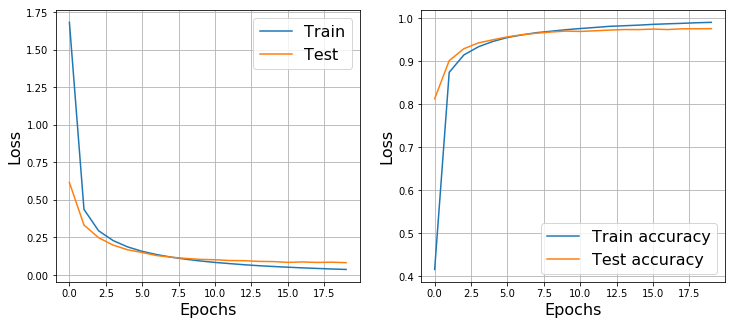

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.079	Accuracy: 0.987/0.976

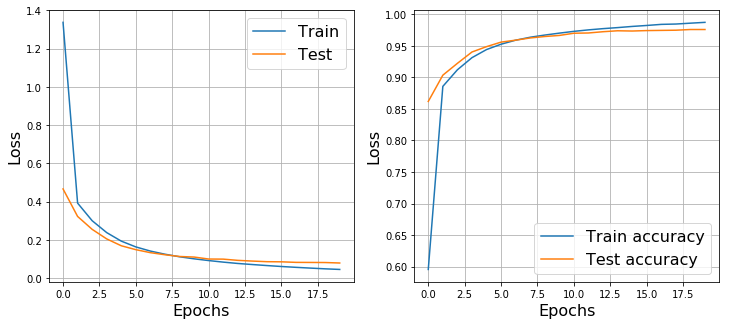

In [15]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

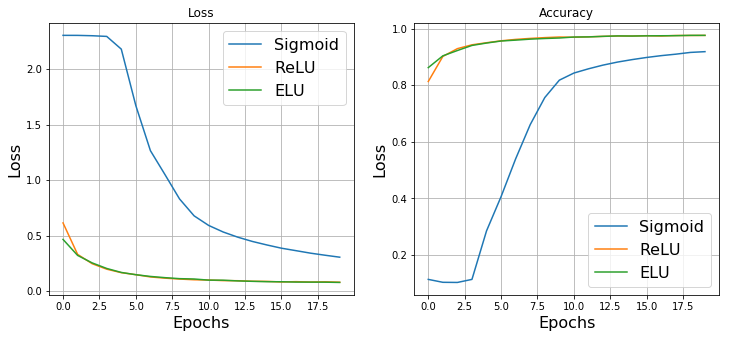

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

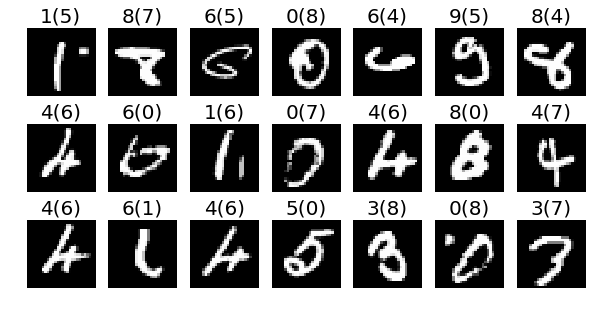

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [74]:
from skimage.transform import rotate

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?